In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import re
from scipy.stats import ttest_ind
import nltk

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist as fdist
import matplotlib.pyplot as plt

In [6]:
df = pd.read_excel('/Users/zhangnele/Downloads/Projects/Quantium/QVI_transaction_data.xlsx')

In [7]:
df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [9]:
df2 = pd.read_csv('/Users/zhangnele/Downloads/Projects/Quantium/QVI_purchase_behaviour.csv')

In [10]:
df2.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [11]:
df.shape

(264836, 8)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
DATE              264836 non-null int64
STORE_NBR         264836 non-null int64
LYLTY_CARD_NBR    264836 non-null int64
TXN_ID            264836 non-null int64
PROD_NBR          264836 non-null int64
PROD_NAME         264836 non-null object
PROD_QTY          264836 non-null int64
TOT_SALES         264836 non-null float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [13]:
df.duplicated().sum()

1

In [14]:
df[df.duplicated()]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
124845,43374,107,107024,108462,45,Smiths Thinly Cut Roast Chicken 175g,2,6.0


In [15]:
df = df.drop_duplicates()

In [16]:
df.columns

Index(['DATE', 'STORE_NBR', 'LYLTY_CARD_NBR', 'TXN_ID', 'PROD_NBR',
       'PROD_NAME', 'PROD_QTY', 'TOT_SALES'],
      dtype='object')

In [17]:
df['DATE'].head()

0    43390
1    43599
2    43605
3    43329
4    43330
Name: DATE, dtype: int64

In [18]:
def xlseriesdate_to_datetime(xlserialdate):
    excel_anchor = datetime.datetime(1900, 1, 1)
    if(xlserialdate < 60):
        delta_in_days = datetime.timedelta(days = (xlserialdate - 1))
    else:
        delta_in_days = datetime.timedelta(days = (xlserialdate - 2))
    converted_date = excel_anchor + delta_in_days
    return converted_date
df['DATE']=df['DATE'].apply(xlseriesdate_to_datetime)

In [19]:
df['DATE'].head()

0   2018-10-17
1   2019-05-14
2   2019-05-20
3   2018-08-17
4   2018-08-18
Name: DATE, dtype: datetime64[ns]

In [20]:
df['PROD_NAME'].head()

0      Natural Chip        Compny SeaSalt175g
1                    CCs Nacho Cheese    175g
2      Smiths Crinkle Cut  Chips Chicken 170g
3      Smiths Chip Thinly  S/Cream&Onion 175g
4    Kettle Tortilla ChpsHny&Jlpno Chili 150g
Name: PROD_NAME, dtype: object

In [21]:
df['PACK_SIZE'] = df['PROD_NAME'].str.extract("(\d+)")
df['PACK_SIZE'] = pd.to_numeric(df['PACK_SIZE'])
df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150


In [22]:
def clean_text(text):
    text = re.sub('[&/]', ' ', text) # remove special characters '&' and '/'
    text = re.sub('\d\w*', ' ', text) # remove product weights
    return text
df['PROD_NAME'] = df['PROD_NAME'].apply(clean_text)

In [23]:
df['PROD_NAME'].head()

0      Natural Chip        Compny SeaSalt 
1                    CCs Nacho Cheese     
2      Smiths Crinkle Cut  Chips Chicken  
3      Smiths Chip Thinly  S Cream Onion  
4    Kettle Tortilla ChpsHny Jlpno Chili  
Name: PROD_NAME, dtype: object

In [24]:
prodWord = word_tokenize(' '.join(df['PROD_NAME']))

In [25]:
wordFrequency = fdist(prodWord)

In [26]:
wordFrequency
#wordFrequency.items()

FreqDist({'Chips': 49770, 'Kettle': 41288, 'Smiths': 28859, 'Salt': 27976, 'Cheese': 27890, 'Pringles': 25102, 'Doritos': 24962, 'Crinkle': 23960, 'Corn': 22063, 'Original': 21560, ...})

In [27]:
freq_df = pd.DataFrame(list(wordFrequency.items()), columns = ["Word", "Frequency"])
freq_df.head()

,Word,Frequency
0,Natural,6050
1,Chip,18645
2,Compny,1468
3,SeaSalt,1468
4,CCs,4551


In [28]:
freq_df = freq_df.sort_values(by = 'Frequency', ascending = False)
freq_df.head()

,Word,Frequency
10,Chips,49770
16,Kettle,41288
7,Smiths,28859
28,Salt,27976
6,Cheese,27890


In [29]:
df = df[~df['PROD_NAME'].str.contains("Salsa")]
df['PROD_NAME'] = df['PROD_NAME'].apply(lambda x: x.title())

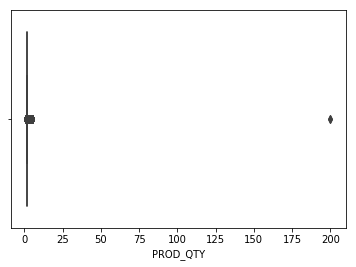

In [30]:
sns.boxplot(x = df['PROD_QTY']);

In [31]:
df[df['PROD_QTY']>175]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme,200,650.0,380
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme,200,650.0,380


In [32]:
df.drop(df.index[df['LYLTY_CARD_NBR'] == 226000], inplace = True)

In [33]:
df2.drop(df2.index[df2['LYLTY_CARD_NBR'] == 226000], inplace = True)

In [34]:
df['DATE'].nunique()

364

In [35]:
pd.date_range(start = '2018-07-01', end = '2019-06-30').difference(df['DATE'])

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)

In [36]:
a = pd.pivot_table(df, values = 'TOT_SALES', index = 'DATE', aggfunc = 'sum')
a.head()

,TOT_SALES
DATE,
2018-07-01,4920.1
2018-07-02,4877.0
2018-07-03,4954.7
2018-07-04,4968.1
2018-07-05,4682.0


In [37]:
b = pd.DataFrame(index = pd.date_range(start = '2018-07-01', end = '2019-06-30'))
b['TOT_SALES'] = 0
b.head()

,TOT_SALES
2018-07-01,0
2018-07-02,0
2018-07-03,0
2018-07-04,0
2018-07-05,0


In [38]:
c = a + b
c.fillna(0, inplace = True)

In [39]:
c.head()

,TOT_SALES
2018-07-01,4920.1
2018-07-02,4877.0
2018-07-03,4954.7
2018-07-04,4968.1
2018-07-05,4682.0


In [40]:
c.index.name = 'Date'
c.rename(columns = {'TOT_SALES': 'Total Sales'}, inplace = True)

In [41]:
c.head()

,Total Sales
Date,
2018-07-01,4920.1
2018-07-02,4877.0
2018-07-03,4954.7
2018-07-04,4968.1
2018-07-05,4682.0


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


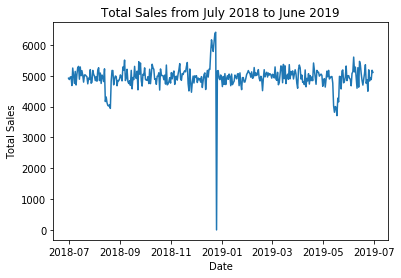

In [42]:
ax = sns.lineplot(x = c.index, y = 'Total Sales', data = c);
ax.set_title('Total Sales from July 2018 to June 2019');
# we can see that the sales peaks in Dec before Christmas and 0 on Chrismas day.

In [43]:
c_december = c[(c.index < "2019-01-01") & (c.index > "2018-11-30")]

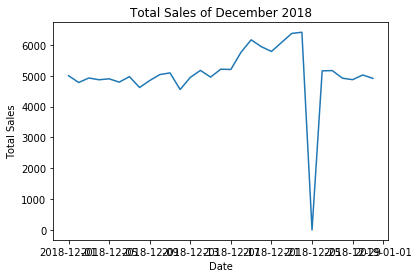

In [44]:
ax2 = sns.lineplot(x = c_december.index, y = 'Total Sales', data = c_december);
ax2.set_title('Total Sales of December 2018');

In [45]:
df['PACK_SIZE'].unique()

array([175, 170, 150, 330, 210, 270, 220, 125, 110, 134, 380, 180, 165,
       135, 250, 200, 160, 190,  90,  70])

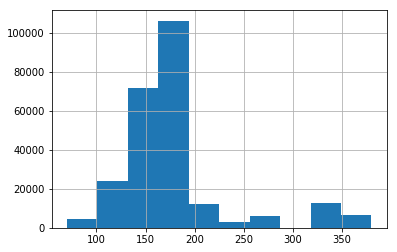

In [46]:
df['PACK_SIZE'].hist();

In [47]:
part = df['PROD_NAME'].str.partition()

In [48]:
df['brand'] = part[0]

In [49]:
df['brand'].unique()

array(['Natural', 'Ccs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'Ww', 'Thins', 'Burger', 'Ncc', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'Grnwves',
       'Tyrrells', 'Cobs', 'French', 'Rrd', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

In [50]:
df['brand'].replace('Ncc', 'Natural', inplace = True)
df['brand'].replace('Ccs', 'CCS', inplace = True)
df['brand'].replace('Smith', 'Smiths', inplace = True)
df['brand'].replace(['Grain', 'Grnwves'], 'Grainwaves', inplace = True)
df['brand'].replace('Dorito', 'Doritos', inplace = True)
df['brand'].replace('Ww', 'Woolworths', inplace = True)
df['brand'].replace('Infzns', 'Infuzions', inplace = True)
df['brand'].replace(['Red', 'Rrd'], 'Red Rock Deli', inplace = True)
df['brand'].replace('Snbts', 'Sunbites', inplace = True)

df['brand'].unique()

array(['Natural', 'CCS', 'Smiths', 'Kettle', 'Grainwaves', 'Doritos',
       'Twisties', 'Woolworths', 'Thins', 'Burger', 'Cheezels',
       'Infuzions', 'Red Rock Deli', 'Pringles', 'Tyrrells', 'Cobs',
       'French', 'Tostitos', 'Cheetos', 'Sunbites'], dtype=object)

In [51]:
df.groupby('brand').TOT_SALES.sum().sort_values(ascending = False)

brand
Kettle           390239.8
Doritos          226329.9
Smiths           217486.0
Pringles         177655.5
Infuzions         99047.6
Thins             88852.5
Red Rock Deli     87607.5
Twisties          81522.1
Tostitos          79789.6
Cobs              70569.8
Tyrrells          51647.4
Grainwaves        51617.2
Natural           42318.0
Woolworths        41059.1
Cheezels          40029.9
CCS               18078.9
Cheetos           16884.5
Sunbites           9676.4
French             7929.0
Burger             6831.0
Name: TOT_SALES, dtype: float64

In [52]:
df_brand = df.groupby('brand').TOT_SALES.sum().sort_values(ascending = False).reset_index(name='total sales')
df_brand.head()

,brand,total sales
0,Kettle,390239.8
1,Doritos,226329.9
2,Smiths,217486.0
3,Pringles,177655.5
4,Infuzions,99047.6


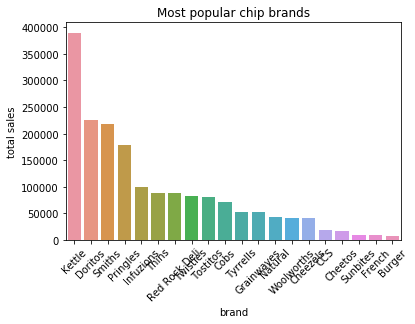

In [53]:
brand = sns.barplot(x='brand', y='total sales', data=df_brand);
brand.set_xticklabels(brand.get_xticklabels(), rotation=45);
brand.set_title('Most popular chip brands');
#top 4 most popular chip brands are Kettle, Doriros, Smiths and Pringles

In [54]:
df2.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [55]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72636 entries, 0 to 72636
Data columns (total 3 columns):
LYLTY_CARD_NBR      72636 non-null int64
LIFESTAGE           72636 non-null object
PREMIUM_CUSTOMER    72636 non-null object
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


In [56]:
df2[df2.duplicated()]

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER


In [57]:
df2['LIFESTAGE'].unique()

array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
       'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
       'RETIREES'], dtype=object)

In [58]:
df2['LIFESTAGE'].value_counts()

RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9779
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64

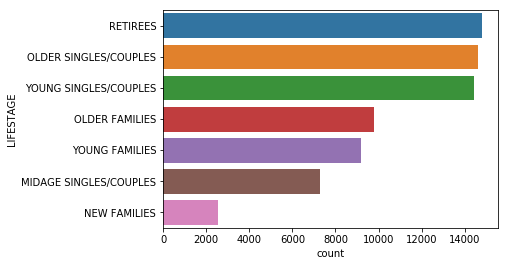

In [59]:
sns.countplot(y = 'LIFESTAGE', order = df2['LIFESTAGE'].value_counts().index, data = df2);

In [60]:
df2['PREMIUM_CUSTOMER'].value_counts()

Mainstream    29245
Budget        24470
Premium       18921
Name: PREMIUM_CUSTOMER, dtype: int64

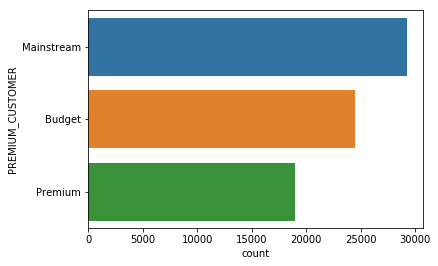

In [61]:
sns.countplot(y = df2['PREMIUM_CUSTOMER'], order = df2['PREMIUM_CUSTOMER'].value_counts().index);

In [62]:
df3 = pd.merge(df, df2, on='LYLTY_CARD_NBR')

In [63]:
df3.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,brand,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175,CCS,MIDAGE SINGLES/COUPLES,Budget
2,2018-11-10,1,1307,346,96,Ww Original Stacked Chips,2,3.8,160,Woolworths,MIDAGE SINGLES/COUPLES,Budget
3,2019-03-09,1,1307,347,54,Ccs Original,1,2.1,175,CCS,MIDAGE SINGLES/COUPLES,Budget
4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget


In [64]:
df3.shape

(246739, 12)

In [65]:
df3.to_csv (r'/Users/zhangnele/Downloads/QVI.csv', index = False, header=True)

In [66]:
df3.isnull().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
brand               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

### Data analysis on customer segments: 
Now that our data is ready for analysis, we can define some metrics of interest to the client:

1. Who spends the most on chips, describing customers by lifestage and how premium their general purchasing behaviour is
2. How many customers are in each segment
3. How many chips are bought per customer by segment
4. What is the average chip price by customer segment

In [67]:
# 1. Who spends the most on chips, describing customers by lifestage 
# and how premium their general purchasing behaviour is.
df3.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,brand,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175,CCS,MIDAGE SINGLES/COUPLES,Budget
2,2018-11-10,1,1307,346,96,Ww Original Stacked Chips,2,3.8,160,Woolworths,MIDAGE SINGLES/COUPLES,Budget
3,2019-03-09,1,1307,347,54,Ccs Original,1,2.1,175,CCS,MIDAGE SINGLES/COUPLES,Budget
4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget


In [68]:
Sales=df3.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).TOT_SALES.sum().sort_values(ascending = False).reset_index(name = 'Total Sales')

In [69]:
Sales.head()
#Sales are coming from budget older families, mainstream young singles/couples and mainstream retirees

,PREMIUM_CUSTOMER,LIFESTAGE,Total Sales
0,Budget,OLDER FAMILIES,156863.75
1,Mainstream,YOUNG SINGLES/COUPLES,147582.20
2,Mainstream,RETIREES,145168.95
3,Budget,YOUNG FAMILIES,129717.95
4,Budget,OLDER SINGLES/COUPLES,127833.60


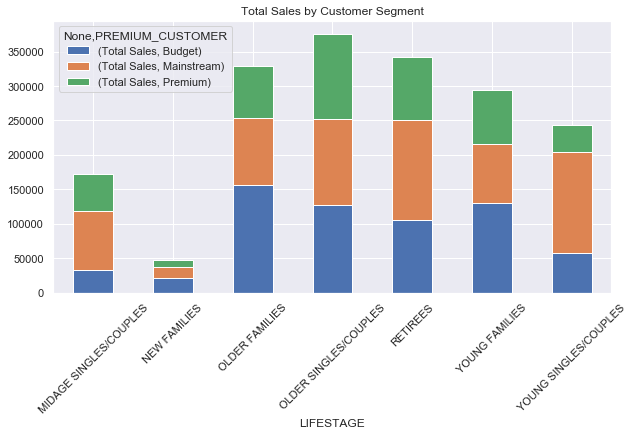

In [70]:
sns.set()
SalesPlot = pd.pivot_table(Sales, values = 'Total Sales', index = ['LIFESTAGE', 'PREMIUM_CUSTOMER']).sort_values(by='Total Sales', ascending = False)
SalesPlot = SalesPlot.unstack()
SalesPlot2 = SalesPlot.plot(kind = 'bar', stacked = True, figsize = (10, 5), title = 'Total Sales by Customer Segment');
SalesPlot2.set_xticklabels(SalesPlot2.get_xticklabels(), rotation=45);



In [78]:
SalesPlot.head()

Total Sales                      
PREMIUM_CUSTOMER            Budget Mainstream    Premium
LIFESTAGE                                               
MIDAGE SINGLES/COUPLES    33345.70   84734.25   54443.85
NEW FAMILIES              20607.45   15979.70   10760.80
OLDER FAMILIES           156863.75   96413.55   75242.60
OLDER SINGLES/COUPLES    127833.60  124648.50  123531.55
RETIREES                 105916.30  145168.95   91296.65

In [112]:
SalesPlot.unstack().sort_values(ascending=False).reset_index().head()

,level_0,PREMIUM_CUSTOMER,LIFESTAGE,0
0,Total Sales,Budget,OLDER FAMILIES,156863.75
1,Total Sales,Mainstream,YOUNG SINGLES/COUPLES,147582.20
2,Total Sales,Mainstream,RETIREES,145168.95
3,Total Sales,Budget,YOUNG FAMILIES,129717.95
4,Total Sales,Budget,OLDER SINGLES/COUPLES,127833.60


In [76]:
df_premium = df3.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).LYLTY_CARD_NBR.nunique().sort_values(ascending = False).reset_index(name='counts')
df_premium.head(6)
# number of Mainstream young singles/couples and retirees are more than older families but the sales of older familiers
# are more than these segmentations. Which indicates that each older families buy more chips than other segments.

,PREMIUM_CUSTOMER,LIFESTAGE,counts
0,Mainstream,YOUNG SINGLES/COUPLES,7917
1,Mainstream,RETIREES,6358
2,Mainstream,OLDER SINGLES/COUPLES,4858
3,Budget,OLDER SINGLES/COUPLES,4849
4,Premium,OLDER SINGLES/COUPLES,4682
5,Budget,OLDER FAMILIES,4611


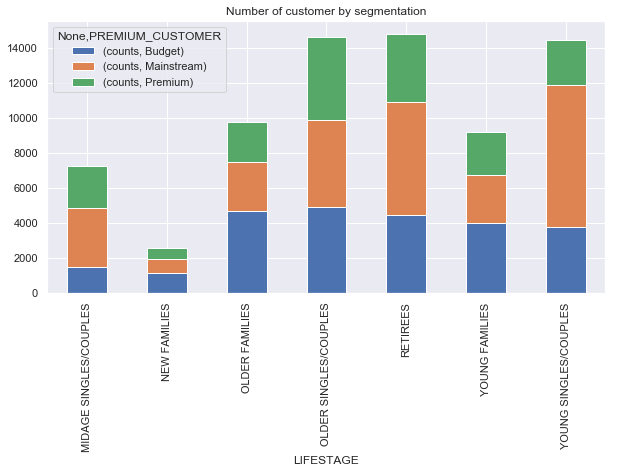

In [409]:
premium_counts = pd.pivot_table(df_premium, values = 'counts', index=['LIFESTAGE', 'PREMIUM_CUSTOMER']).unstack()
premium_counts.plot(kind = 'bar', stacked = True, figsize = (10, 5), title = 'Number of customer by segmentation');

In [420]:
unit_pack = df3.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).TOT_SALES.sum().unstack()/df3.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique().unstack()

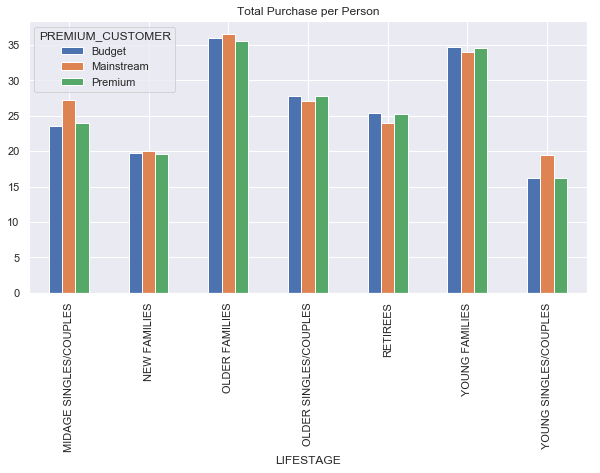

In [426]:
unit_pack.plot(kind = 'bar', stacked = False, figsize = (10, 5), title = 'Total Purchase per Person');
# older families and young families spend more than other segments per customer. And also we can
# see that midage singles/couples and yong singles/couples spend more on maintream chips than other kind of chips.

In [431]:
avg_price = df3.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).TOT_SALES.sum() / df3.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).PROD_QTY.sum()
avg_price = pd.DataFrame(avg_price, columns = {'Price per Unit'})
avg_price.sort_values(by = 'Price per Unit', ascending = False).head()
#maintream young singles/couples and midage singles/couples are willing to pay more per package comparing to thier budget
#and premium counterparts.

Price per Unit
LIFESTAGE              PREMIUM_CUSTOMER                
YOUNG SINGLES/COUPLES  Mainstream              4.080079
MIDAGE SINGLES/COUPLES Mainstream              4.000346
NEW FAMILIES           Mainstream              3.939315
                       Budget                  3.936178
RETIREES               Budget                  3.933660

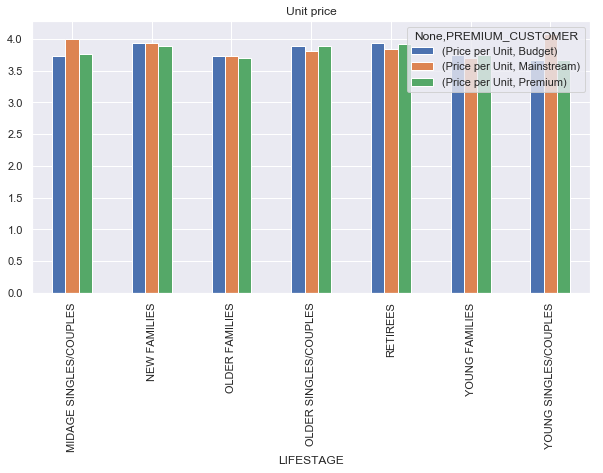

In [433]:
avg_price.unstack().plot(kind = 'bar', stacked = False, figsize = (10, 5), title = 'Unit price');

In [465]:
# As this difference in average price per unit us not too large
# perform an independent t-test between mainstram vs non-mainstream midage and young singles/couples
pricePerUnit = df3
pricePerUnit['PRICE'] = pricePerUnit['TOT_SALES']/pricePerUnit['PROD_QTY']
pricePerUnit.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,brand,LIFESTAGE,PREMIUM_CUSTOMER,PRICE
0,2018-10-17,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium,3.00
1,2019-05-14,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175,CCS,MIDAGE SINGLES/COUPLES,Budget,2.10
2,2018-11-10,1,1307,346,96,Ww Original Stacked Chips,2,3.8,160,Woolworths,MIDAGE SINGLES/COUPLES,Budget,1.90
3,2019-03-09,1,1307,347,54,Ccs Original,1,2.1,175,CCS,MIDAGE SINGLES/COUPLES,Budget,2.10
4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget,1.45


In [480]:
#group the data into mainstream and non-mainstream
mainstream = pricePerUnit.loc[pricePerUnit['PREMIUM_CUSTOMER']=='Mainstream']
mainstream = mainstream.loc[pricePerUnit['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES','MIDAGE SINGLES/COUPLES'])]   
Premium = pricePerUnit.loc[(pricePerUnit['PREMIUM_CUSTOMER']=='Premium')]
Premium = Premium.loc[pricePerUnit['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES','MIDAGE SINGLES/COUPLES'])]
                                  
                                  

In [466]:
mainstream.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,brand,LIFESTAGE,PREMIUM_CUSTOMER,PRICE
5021,2019-05-18,3,3159,1759,77,Doritos Corn Chips Nacho Cheese,2,8.8,170,Doritos,MIDAGE SINGLES/COUPLES,Mainstream,4.4
5022,2019-03-23,3,3159,1757,36,Kettle Chilli,2,10.8,175,Kettle,MIDAGE SINGLES/COUPLES,Mainstream,5.4
5023,2019-05-10,3,3159,1758,81,Pringles Original Crisps,2,7.4,134,Pringles,MIDAGE SINGLES/COUPLES,Mainstream,3.7
5024,2019-05-16,3,3294,2370,51,Doritos Mexicana,2,8.8,170,Doritos,MIDAGE SINGLES/COUPLES,Mainstream,4.4
5025,2019-04-22,3,3294,2369,114,Kettle Sensations Siracha Lime,2,9.2,150,Kettle,MIDAGE SINGLES/COUPLES,Mainstream,4.6


Text(0.5, 0, 'Price per Unit')

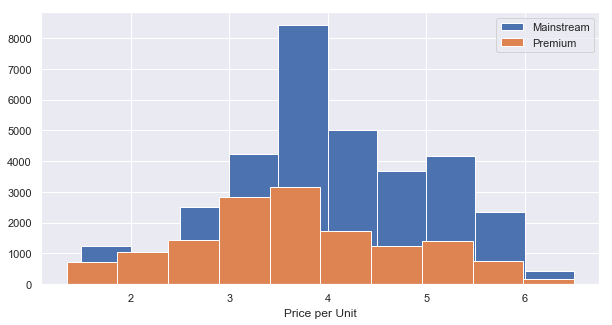

In [481]:
plt.figure(figsize = (10, 5))
plt.hist(mainstream['PRICE'], label = 'Mainstream')
plt.hist(non_mainstream['PRICE'], label = 'Premium')
plt.legend()
plt.xlabel('Price per Unit')


In [477]:
[np.mean(mainstream['PRICE']), np.mean(non_mainstream['PRICE'])]

[4.045586042532171, 3.7063840794647005]

In [478]:
ttest_ind(mainstream['PRICE'], non_mainstream['PRICE'])
# The difference between mean of mainstream and premium is significant. that is to say
# the mainstream product unit price is significantly higher than premium product.

Ttest_indResult(statistic=31.802755248380716, pvalue=1.2488894299209027e-219)

In [482]:
Budget = pricePerUnit.loc[(pricePerUnit['PREMIUM_CUSTOMER']=='Budget')]
Budget = Budget.loc[pricePerUnit['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES','MIDAGE SINGLES/COUPLES'])]
                                  

Text(0.5, 0, 'Price per Unit')

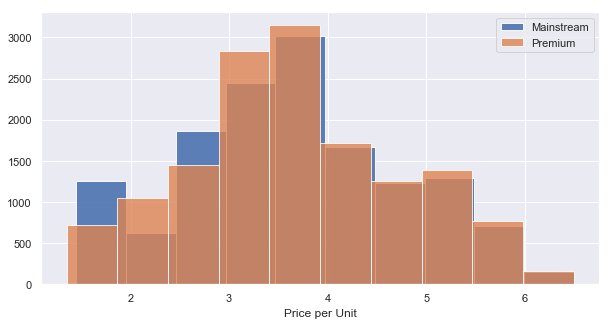

In [493]:
plt.figure(figsize = (10, 5))
plt.hist(Budget['PRICE'], label = 'Budget',alpha=0.9)
plt.hist(Premium['PRICE'], label = 'Premium', alpha=0.8)
plt.legend()
plt.xlabel('Price per Unit')

In [485]:
[np.mean(Budget['PRICE']), np.mean(Premium['PRICE'])]

[3.6696466133781835, 3.7063840794647005]

In [486]:
ttest_ind(Budget['PRICE'], Premium['PRICE'])
# The difference between mean of Budget and premium is significant. that is to say
# the Budget product unit price is significantly lower than premium product. But the difference is less tham
# the difference between mainstream and premium.

Ttest_indResult(statistic=-2.7536893997583367, pvalue=0.005896465924038022)

In [495]:
df3.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,brand,LIFESTAGE,PREMIUM_CUSTOMER,PRICE
0,2018-10-17,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium,3.00
1,2019-05-14,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175,CCS,MIDAGE SINGLES/COUPLES,Budget,2.10
2,2018-11-10,1,1307,346,96,Ww Original Stacked Chips,2,3.8,160,Woolworths,MIDAGE SINGLES/COUPLES,Budget,1.90
3,2019-03-09,1,1307,347,54,Ccs Original,1,2.1,175,CCS,MIDAGE SINGLES/COUPLES,Budget,2.10
4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget,1.45


In [549]:
# Examine mainstream young singles/couples against the rest
# of the customer segments
target = df3.loc[(df3['LIFESTAGE']=='YOUNG SINGLES/COUPLES') & (df3['PREMIUM_CUSTOMER']=='Mainstream')]

In [550]:
non_target = df3.loc[(df3['LIFESTAGE']=='YOUNG SINGLES/COUPLES') & (df3['PREMIUM_CUSTOMER']!='Mainstream')]

In [551]:
# Preference to brand
targetBrand = target.loc[:, ['brand', 'PROD_QTY']]
targetSum = targetBrand['PROD_QTY'].sum()
targetBrand['Target Brand Preference']=targetBrand['PROD_QTY']/targetSum
targetBrand = pd.DataFrame(targetBrand.groupby('brand')['Target Brand Preference'].sum())

non_targetBrand = non_target.loc[:, ['brand', 'PROD_QTY']]
non_targetSum = non_targetBrand['PROD_QTY'].sum()
non_targetBrand['Non Target Brand Preference']=non_targetBrand['PROD_QTY']/non_targetSum
non_targetBrand = pd.DataFrame(non_targetBrand.groupby('brand')['Non Target Brand Preference'].sum())

In [558]:
targetBrand.sort_values(by = 'Target Brand Preference', ascending = False).head()
# in young singles/couples segment, the top chip brands are Kettle, Doritos and Pringles

,Target Brand Preference
brand,
Kettle,0.197985
Doritos,0.122761
Pringles,0.119420
Smiths,0.096370
Infuzions,0.064679


In [560]:
non_targetBrand.sort_values(by = 'Non Target Brand Preference', ascending = False).head()
# the top chip brands among non_mainstream group are Kettle, Smiths, Pringles. Kettle are most poplular brand amoung
# young singles/couples.

,Non Target Brand Preference
brand,
Kettle,0.146539
Smiths,0.134190
Pringles,0.096299
Doritos,0.090431
Red Rock Deli,0.075053


In [552]:
brand_proportions = pd.merge(targetBrand, non_targetBrand, left_index = True, right_index=True)

In [553]:
brand_proportions.head()

,Target Brand Preference,Non Target Brand Preference
brand,,
Burger,0.002926,0.007939
CCS,0.011180,0.024890
Cheetos,0.008033,0.013193
Cheezels,0.017971,0.018562
Cobs,0.044638,0.037354


In [554]:
brand_proportions['Brand Preference'] = brand_proportions['Target Brand Preference']/brand_proportions['Non Target Brand Preference']

In [555]:
brand_proportions.sort_values(by = 'Brand Preference', ascending = False)
# for target segment young singles/couples, they prefer Kettle and Doritos most. if comparing with mainstream and 
# non mainstream, Doritos is more poplular among target segment than non_target group.

,Target Brand Preference,Non Target Brand Preference,Brand Preference
brand,,,
Doritos,0.122761,0.090431,1.357498
Kettle,0.197985,0.146539,1.351074
Tostitos,0.045411,0.034094,1.331926
Tyrrells,0.031553,0.023854,1.322732
Twisties,0.046184,0.035091,1.316106
Pringles,0.119420,0.096299,1.240097
Infuzions,0.064679,0.053883,1.200361
Cobs,0.044638,0.037354,1.194997
Grainwaves,0.032712,0.029875,1.094956


In [561]:
df3.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,brand,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175,CCS,MIDAGE SINGLES/COUPLES,Budget
2,2018-11-10,1,1307,346,96,Ww Original Stacked Chips,2,3.8,160,Woolworths,MIDAGE SINGLES/COUPLES,Budget
3,2019-03-09,1,1307,347,54,Ccs Original,1,2.1,175,CCS,MIDAGE SINGLES/COUPLES,Budget
4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget


In [563]:
target.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,brand,LIFESTAGE,PREMIUM_CUSTOMER
221345,2018-08-16,1,1020,26,19,Smiths Crinkle Cut Snag Sauce,1,2.6,150,Smiths,YOUNG SINGLES/COUPLES,Mainstream
221346,2018-10-02,1,1020,27,7,Smiths Crinkle Original,1,5.7,330,Smiths,YOUNG SINGLES/COUPLES,Mainstream
221347,2019-05-02,1,1020,28,84,Grnwves Plus Btroot Chilli Jam,1,3.1,180,Grainwaves,YOUNG SINGLES/COUPLES,Mainstream
221348,2018-08-17,1,1163,188,46,Kettle Original,1,5.4,175,Kettle,YOUNG SINGLES/COUPLES,Mainstream
221349,2019-02-07,1,1163,189,12,Natural Chip Co Tmato Hrb Spce,1,3.0,175,Natural,YOUNG SINGLES/COUPLES,Mainstream


In [565]:
# Preference to package size
targetPack = target.loc[:, ['PACK_SIZE', 'PROD_QTY']]
targetPackSum = targetPack['PROD_QTY'].sum()
targetPack['Target Pack Preference']=targetPack['PROD_QTY']/targetPackSum
targetPack = pd.DataFrame(targetPack.groupby('PACK_SIZE')['Target Pack Preference'].sum())

non_targetPack = non_target.loc[:, ['PACK_SIZE', 'PROD_QTY']]
non_targetPackSum = non_targetPack['PROD_QTY'].sum()
non_targetPack['Non Target Pack Preference']=non_targetPack['PROD_QTY']/non_targetPackSum
non_targetPack = pd.DataFrame(non_targetPack.groupby('PACK_SIZE')['Non Target Pack Preference'].sum())

In [568]:
targetPack.sort_values(by = 'Target Pack Preference', ascending = False).head()

,Target Pack Preference
PACK_SIZE,
175,0.254990
150,0.157598
134,0.119420
110,0.106280
170,0.080773


In [566]:
non_targetPack.sort_values(by = 'Non Target Pack Preference', ascending = False).head()

,Non Target Pack Preference
PACK_SIZE,
175,0.273595
150,0.160920
134,0.096299
110,0.083145
170,0.081342


In [569]:
pack_proportions = pd.merge(targetPack, non_targetPack, left_index = True, right_index=True)

In [571]:
pack_proportions['Pack Preference'] = pack_proportions['Target Pack Preference']/pack_proportions['Non Target Pack Preference']

In [574]:
pack_proportions.sort_values(by='Pack Preference', ascending=False).head()
# for both taget, and non target, the most popular pack size is 175. 
# for target group, 330 and 380 are more popular than in non target group.

,Target Pack Preference,Non Target Pack Preference,Pack Preference
PACK_SIZE,,,
330,0.061284,0.043490,1.409146
380,0.032160,0.023011,1.397625
270,0.031829,0.022934,1.387855
110,0.106280,0.083145,1.278255
134,0.119420,0.096299,1.240097
